In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add
import collections
import os

Using TensorFlow backend.


In [5]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model_new = Model(input=model.input,output = model.layers[-2].output)

/Users/paraskaushik/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("av...)`
  


In [2]:
def predict_captions(photo):
    in_text = "<s>"
    for i in range(max_len):
        sequence = [word_to_index[w] for w in in_text.split() if w in word_to_index]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')

        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax()
        word = index_to_word[ypred]
        in_text += ' '+word
        if word == "<e>":model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()
            break
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)

    return final_caption

In [4]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    
    img = preprocess_input(img)
    return img

In [6]:
def encode_img(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    #print(feature_vector.shape)
    feature_vector = feature_vector.reshape((-1,))
    return feature_vector

In [11]:
max_len=74
vocab_size=5121

In [14]:
embedding_matrix = None
with open("embedding_matrix.pkl",'rb') as f:
       embedding_matrix = pickle.load(f)

In [18]:
word_to_index = None
with open("word_to_index.pkl",'rb') as f:
       word_to_index = pickle.load(f)

In [21]:
index_to_word = None
with open("index_to_word.pkl",'rb') as f:
       index_to_word = pickle.load(f)

In [65]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

model.load_weights("model_weights/model_37.h5")

In [66]:
img_path = "/Users/paraskaushik/Desktop/FOOD/CODES/DATA_SCIENCE/Image Captioning Bot/8k/flickr8k/Flickr_Data/Flickr_Data/Images/"

woman in red shirt is carrying red roses


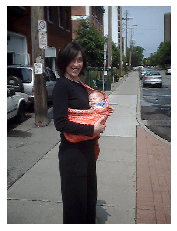

dog with muzzle is running through the grass


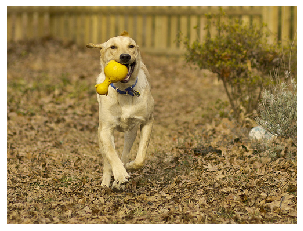

man in blue shirt and blue jeans is sitting on swing in the sunlight


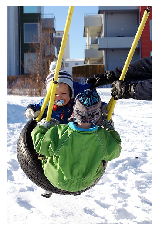

brown dog runs through field


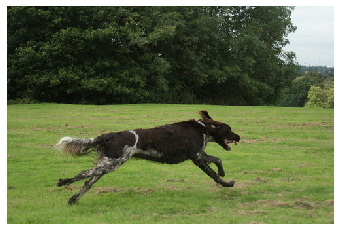

black dog catches red ball in the snow


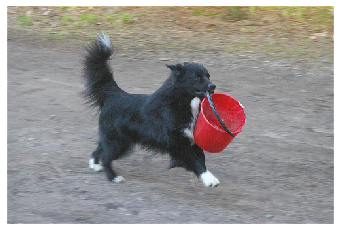

group of children are running in the water


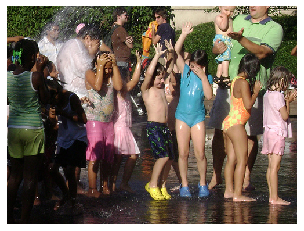

two dogs are playing on the street


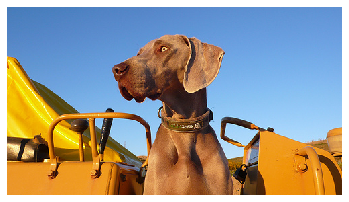

black dog with tennis ball in its mouth


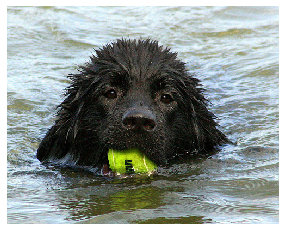

young boy in blue bathing suit is running on the beach


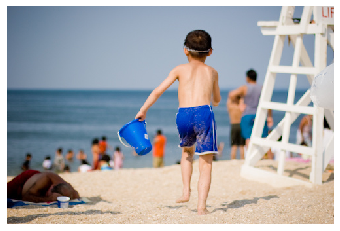

young girl is eating peach


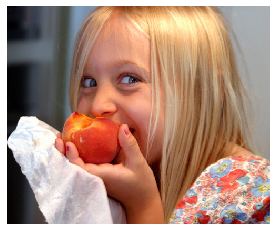

man in black leather jacket and black leather jacket is standing next to man wearing black jacket


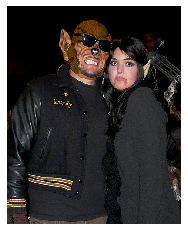

car is parked in front of firetruck


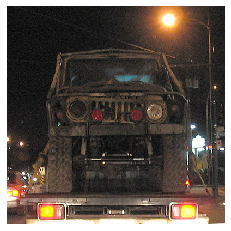

dog runs through the woods


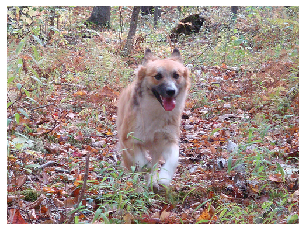

man in white shirt and black pants is standing in front of fountain


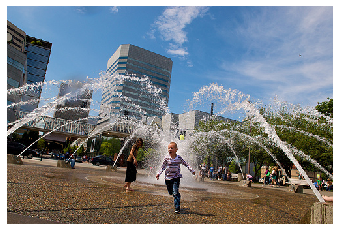

two young boys are sitting on bench


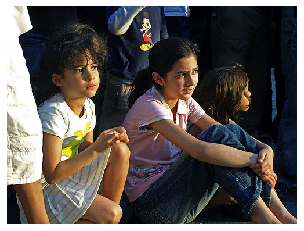

In [67]:
for i in range(15):
    id = np.random.randint(0,1000)
    all_image_names = list(os.listdir(img_path))
    img_name = all_image_names[id]
    photo_2048 = encode_img(img_path+img_name).reshape((1,2048))
    #photo_2048 = encoding_train[img_name].reshape((1,2048))

    i = plt.imread(img_path+img_name)
    caption = predict_captions(photo_2048)
    print(caption)

    plt.imshow(i)
    plt.axis("off")
    plt.show()

In [68]:
def give_caption(image_path):
    photo_2048 = encode_img(image_path).reshape((1,2048))
    caption = predict_captions(photo_2048)
    
    return caption